**Arturo Lazcano**

En esta tarea van a crear una red neuronal que clasifique mensajes como spam o no spam. Lo primero es descargar la data:

In [1]:
!wget https://www.ivan-sipiran.com/downloads/spam.csv

--2023-11-17 23:06:45--  https://www.ivan-sipiran.com/downloads/spam.csv
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471781 (461K)
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 460.72K  1.57MB/s    in 0.3s    

2023-11-17 23:06:45 (1.57 MB/s) - ‘spam.csv’ saved [471781/471781]



Los datos vienen en un archivo CSV que contiene dos columnas "text" y "label". La columna "text" contiene el texto del mensaje y la columna "label" contiene las etiquetas "ham" y "spam". Un mensaje "ham" es un mensaje que no se considera spam.

# Tarea
El objetivo de la tarea es crear una red neuronal que clasifique los datos entregados. Para lograr esto debes:



*   Implementar el pre-procesamiento de los datos que creas necesario.
*   Particionar los datos en 70% entrenamiento, 10% validación y 20% test.
*   Usa los datos de entrenamiento y valiadación para tus experimentos y sólo usa el conjunto de test para reportar el resultado final.

Para el diseño de la red neuronal puedes usar una red neuronal recurrente o una red basada en transformers. El objetivo de la tarea no es obtener el performance ultra máximo, sino entender qué decisiones de diseño afectan la solución de un problema como este. Lo que si es necesario (como siempre) es que discutas los resultados y decisiones realizadas.



## Imports y Lectura de Dataframe

In [2]:
# Import básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from nltk.tokenize import RegexpTokenizer
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [3]:
# Quitar warnings (opcional)
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Fijar semilla
seed = 69
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Leer dataframe
df = pd.read_csv('spam.csv')
df

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


## Análisis Exploratorio de Datos

El objetivo de esta sección es observar los datos y tener una mejor idea de qué es lo que se está manipulando junto con tener ideas claras al saber que se debe hacer en el procesamiento de los datos, ya sea agregar/quitar columnas, eliminar o modificar valores nulos, entre otros.

In [6]:
# Filas y Columnas
n_row = df.shape[0]
n_col = df.shape[1]
print(f'El dataframe posee {n_row} filas y {n_col} columnas.')

print('-----------------------------------------------------')

# Valores nulos
print(f'El dataframe tiene {df.isna().sum().sum()} valores nulos.')

print('-----------------------------------------------------')

# Valores nulos detalle
print('Detalle de valores nulos: \n', df.isna().sum())

El dataframe posee 5572 filas y 2 columnas.
-----------------------------------------------------
El dataframe tiene 2 valores nulos.
-----------------------------------------------------
Detalle de valores nulos: 
 text     1
label    1
dtype: int64


In [7]:
# Información del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5571 non-null   object
 1   label   5571 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [8]:
# Descripción del dataframe
df.describe()

,text,label
count,5571,5571
unique,5163,44
top,"Sorry, I'll call later",ham
freq,30,4617


In [9]:
# Valores únicos y frecuancia en columna "label"
vc = df['label'].value_counts()
vc

ham                                                                                                                                                                                                          4617
spam                                                                                                                                                                                                          746
#&gt                                                                                                                                                                                                          136
DECIMAL&gt                                                                                                                                                                                                     13
_                                                                                                                                                               

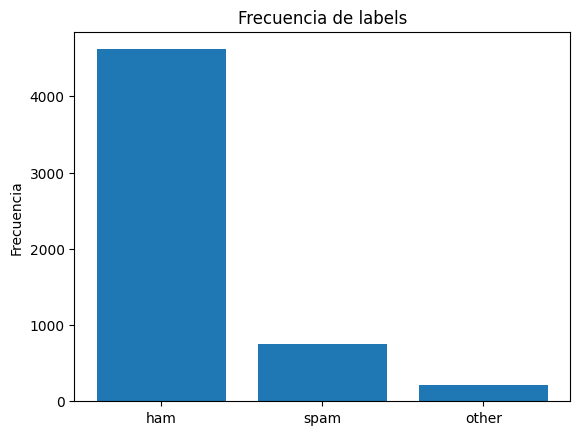

In [10]:
# Graficar frecuencia de labels agrupando
ham = vc['ham']
spam = vc['spam']
other = vc.drop(['ham', 'spam']).sum()

plt.bar(['ham', 'spam', 'other'], [ham, spam, other])
plt.ylabel('Frecuencia')
plt.title('Frecuencia de labels')
plt.show()

En este gráfico se puede ver el balance de los datos tanto para la clase `ham` como para `spam`. Acá se puede observar la diferencia entre ambas clases junto con otras filas de datos que poseen otro tipo de clases.  
Como se pudo ver anteriormente, estas clases que se ven en `other` parecen ser errores al clasificar la data por lo que se opta por removerlos pues no afectan en gran medida al tamaño de la base de datos.

## Procesamiento de Datos

El objetivo de esta sección es incluir el procesamiento que se estime conveniente para que los datos puedan ser manejados por una red neronal sin ningún problema.  

Como se vió en la sección anterior, se opta por remover las 2 filas que poseen nulos en sus columnas junto con aquellas filas que su label es incorrecto, es decir, que no sean de tipo `ham` ni `spam`.  

Dependiendo del tipo de proyecto, la cantidad de datos y el tiempo para trabajar, estos labels podrían ser asignados manualmente, sin embargo, se cree que para esta tarea esto no es necesario y como no representa una gran parte del dataframe se opta por removerlos.

In [11]:
# Remover nulos
df = df.dropna()

# Verificar que no hay valores NaN
print(f'El dataframe tiene {df.isna().sum().sum()} valores nulos.')

El dataframe tiene 0 valores nulos.


In [12]:
# Remover filas con label diferente a ham y spam
df = df[df['label'].isin(['ham', 'spam'])]
df

,text,label
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,spam
5568,Will Ì_ b going to esplanade fr home?,ham
5569,"Pity, * was in mood for that. So...any other s...",ham
5570,The guy did some bitching but I acted like i'd...,ham


In [13]:
# Codificar label como 1--> Spam y 0--> Ham
df = df.replace(to_replace="ham", value=0)
df = df.replace(to_replace="spam", value=1)

In [14]:
# Quitar puntuación y demás de la columna texto
tokenizer = RegexpTokenizer(r'\w+')
df['text'] = df['text'].apply(lambda x: tokenizer.tokenize(x))
df = df.reset_index(drop=True)
df

,text,label
0,"[Go, until, jurong, point, crazy, Available, o...",0
1,"[Ok, lar, Joking, wif, u, oni]",0
2,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",1
3,"[U, dun, say, so, early, hor, U, c, already, t...",0
4,"[Nah, I, don, t, think, he, goes, to, usf, he,...",0
...,...,...
5358,"[This, is, the, 2nd, time, we, have, tried, 2,...",1
5359,"[Will, Ì_, b, going, to, esplanade, fr, home]",0
5360,"[Pity, was, in, mood, for, that, So, any, othe...",0
5361,"[The, guy, did, some, bitching, but, I, acted,...",0


In [15]:
# Crear lista con cada frase (fila) y cada palabra de cada frase
phrases = [text for text in df['text']]
words = [item for sublist in phrases for item in sublist]

In [16]:
counts = Counter(words) #Construye un diccionario de palabras. Las claves son las palabras y los valores son la frecuencia
vocab = sorted(counts, key=counts.get, reverse=True) #Ordenamos la palabras por frecuencia
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)} #Construimos diccionario para mapear palabra a número entero. Empezamos los índices en 1

#Ahora convertimos cada palabra de los reviews en índices
reviews_ints = []
for review in df['text']:
  reviews_ints.append([vocab_to_int[word] for word in review])

In [17]:
#Cuántas palabras hay en el diccionario?
print('Palabras únicas:', len(vocab_to_int))

Palabras únicas: 10467


In [18]:
#Sacamos algunas estadísticas de los datos
review_lens = Counter([len(x) for x in reviews_ints]) #Contamos cuantas palabras hay en cada review
print("Reviews de longitud cero:", review_lens[0])
print('Máxima longitud:', max(review_lens))

Reviews de longitud cero: 2
Máxima longitud: 190


In [19]:
print('Reviews antes de eliminación:', len(reviews_ints))

#Extraemos los índices de todos los reviews que tienen longitud > 0
non_zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review)!=0]
zero_idx = [ii for ii, review in enumerate(reviews_ints) if len(review)==0]

reviews_ints = [reviews_ints[ii] for ii in non_zero_idx]

df = df.drop(zero_idx)
df = df.reset_index(drop=True)

print('Reviews después de eliminación:', len(reviews_ints))

Reviews antes de eliminación: 5363
Reviews después de eliminación: 5361


In [20]:
# Función de padding
def pad_features(reviews_ints, seq_length):
  features = np.zeros((len(reviews_ints), seq_length), dtype=int)

  #Para cada review, se coloca en la matriz
  for i, row in enumerate(reviews_ints):
    features[i, -len(row):] = np.array(row)[:seq_length]

  return features

In [21]:
# Realizar padding
seq_length = 200

features = pad_features(reviews_ints, seq_length=seq_length)

# Extraer los labels como ndarray
encoded_labels = df['label'].to_numpy()

## Clasificación (Pytorch)

En esta sección se usan los datos procesados con anterioridad para así crear datasets que puedan ser legibles para pytorch. Se usa un porcentaje de 70% para entrenamiento, 10% de validación y 20% de test. Luego, se define el `batch_size`, `vocab_size`, `output_size`, `embedding_dim`, `hidden_dim` y `n_layers` como se hizo en el colab del curso. Notar que estos parámetros pueden ser cambiados (excepto `vocab_size` pues lo definimos como el largo de la lista de vocabulario) para mejorar y modificar la red.

In [22]:
split_frac = 0.7

## split data into training, validation, and test data (features and labels, x and y)
split_idx = int(len(features) * split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.66)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeatures:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Features:
Train set: 		(3752, 200) 
Validation set: 	(1061, 200) 
Test set: 		(548, 200)


In [23]:
# crear Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [24]:
# Chequear si tenemos GPU
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
  print('Training on GPU.')
else:
  print('No GPU available, training on CPU.')

Training on GPU.


In [25]:
#Creamos la red neuronal

class SentimentRNN(nn.Module):
  def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
    super(SentimentRNN, self).__init__()

    self.output_size = output_size
    self.n_layers = n_layers
    self.hidden_dim = hidden_dim

    # Capas embedding y LSTM
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                        dropout=drop_prob, batch_first=True)

    # dropout
    self.dropout = nn.Dropout(drop_prob)

    # Capa lineal y sigmoide
    self.fc = nn.Linear(hidden_dim, output_size)
    self.sig = nn.Sigmoid()


  def forward(self, x, hidden):
    embeds = self.embedding(x)
    lstm_out, hidden = self.lstm(embeds, hidden)

    #Tomamos solo el último valor de salida del LSTM
    lstm_out = lstm_out[:,-1,:]

    # dropout y fully-connected
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # sigmoide
    sig_out = self.sig(out)

    # retornar sigmoide y último estado oculto
    return sig_out, hidden


  def init_hidden(self, batch_size):
    # Crea dos nuevos tensores con tamaño n_layers x batch_size x hidden_dim,
    # inicializados a cero, para estado oculto y memoria de LSTM
    weight = next(self.parameters()).data

    if(train_on_gpu):
      hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())

    return hidden

In [26]:
# Instanciamos la red
vocab_size = len(vocab_to_int) + 1 # +1 for zero padding + our word tokens
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(net)

SentimentRNN(
  (embedding): Embedding(10468, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [27]:
# loss and optimization functions
lr = 0.0001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

El parámetro `lr` fue sujeto a cambios durante la realización de esta tarea junto con la cantidad de épocas definida en la celda siguiente, sin embargo, estas se definieron finalmente como `lr = 0.0001` y `epochs = 4` pues se puede ver que el modelo no sobreajusta demasiado entre la loss de entrenamiento y la loss de validación.

In [30]:
# training params

epochs = 4

counter = 0
print_every = 100
clip = 5 # gradient clipping

# Enviar red al GPU
if(train_on_gpu):
  net.cuda()

val_losses = []
train_losses = []

net.train()
# Bucle de entrenamiento
for e in range(epochs):
  # Inicializar estado oculto
  h = net.init_hidden(batch_size)

  # Bucle para batchs
  for inputs, labels in train_loader:
    counter += 1

    if(train_on_gpu):
      inputs, labels = inputs.cuda(), labels.cuda()

    # Crear nuevas variables para estados ocultos, sino se haría
    # backprop para todos los pasos del bucle
    h = tuple([each.data for each in h])

    net.zero_grad()

    #print(inputs.shape, h)
    # Hacer pasada forward
    output, h = net(inputs, h)

    # Calcular loss y hacer backprop
    loss = criterion(output.squeeze(), labels.float())
    loss.backward()
    # gradient clipping
    nn.utils.clip_grad_norm_(net.parameters(), clip)
    optimizer.step()

    # Validation loss
    val_h = net.init_hidden(batch_size)
    val_losses_aux = []
    net.eval()
    for inputs, labels in valid_loader:

      val_h = tuple([each.data for each in val_h])

      if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

      output, val_h = net(inputs, val_h)
      val_loss = criterion(output.squeeze(), labels.float())
      val_losses_aux.append(val_loss.item())

      net.train()

      # Mensajes
      if counter % print_every == 0:
        print("Época: {}/{}...".format(e+1, epochs),
              "Paso: {}...".format(counter),
              "Loss: {:.6f}...".format(loss.item()),
              "Val Loss: {:.6f}".format(np.mean(val_losses_aux)))

    train_losses.append(loss.item())
    #print(val_losses_aux)
    val_losses.append(np.mean(val_losses_aux))

Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.151735
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.179870
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.221412
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.221550
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.257883
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.257196
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.248076
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.237967
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.226716
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.221474
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.223725
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.215117
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.216165
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.214697
Época: 2/4... Paso: 100... Loss: 0.339260... Val Loss: 0.221110
Época: 2/4... Paso: 100... Loss: 0.33926

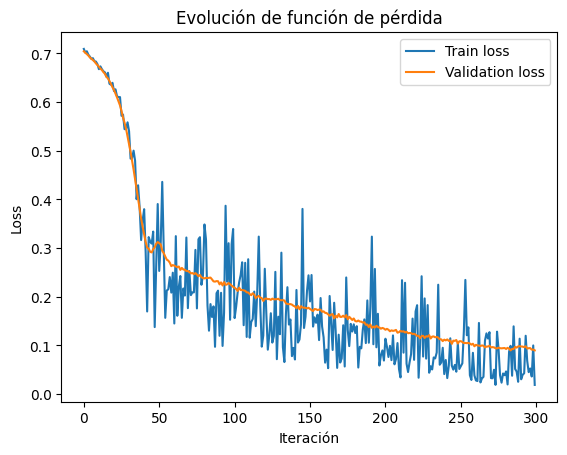

In [39]:
# Graficar loss de entrenamientovalidación
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Iteración')
plt.ylabel('Loss')
plt.title('Evolución de función de pérdida')
plt.legend()
plt.show()

Como se puede ver en el gráfico anterior, se puede ver como la función de pérdida en el conjunto de entrenamiento y validación tiende a bajar (con algunos saltos de por medio). Esto es bueno pues indica que la red está aprendiendo de buena manera y no alcanza a sobreajustar de forma exagerada sus resultados.

In [40]:
# Calcular accuracy de test

test_losses = [] # track loss
num_correct = 0

# Iniciar estado oculto
h = net.init_hidden(batch_size)

net.eval()
for inputs, labels in test_loader:

    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    output, h = net(inputs, h)

    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # Convertir probabilidades a clases (0,1)
    pred = torch.round(output.squeeze())

    # Comparar predicciones a labels
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# Accuracy de test
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.055
Test accuracy: 0.900


En la celda anterior se pueden observar los resultados finales, donde por un lado se obtuvo una pérdida en el conjunto de prueba de `0.055` y una precisión (accuracy) de `0.9` el cual representa buenos resultados para el poco tiempo de entrenamiento que tuvo (recordar que esto fue más que nada por el sobreajuste).

In [42]:
# Mostrar evolución de pérdida en conjunto test
print('Test Loss:\n')
for tl in test_losses:
  print(tl)

Test Loss:

0.030680114403367043
0.058193791657686234
0.13117115199565887
0.01673910766839981
0.024045437574386597
0.025233924388885498
0.01526615023612976
0.09541375935077667
0.08769331872463226
0.06247604638338089


Por último se puede ver la evolución de la función de pérdida en el conjunto de prueba.  
Debido a la cantidad de datos y las proporciones elegidas para el test set, hay pocos puntos por graficar por lo que en general el gráfico no nos aporta una gran información en este aspecto, sin embargo, se puede ver como todos lo puntos evaluados están dentro de un rango bajo en el eje y, es decir, entre $[0, 0.15]$ por lo que se considera que se obtuvieron buenos resultados en esta tarea de clasificación de mensajes de texto.